# Plot

In [34]:
import pandas as pd
import ast
import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

### Load the csv file

In [35]:
# df = pd.read_csv('best-books.csv',index_col='book_index')
# df.index.name = None
df = pd.read_csv(r'C:\Users\Igor\Documents\GitHub\Groupwork-Best-Books-Ever-Challenge\best-books.csv')
# print(df.shape)
# df.head(2)

### Add column for num of awards:

In [36]:
df = df.replace({'awards': {np.nan: 0}})
d = []

for i in df.index:
    if df.loc[i, "awards"] == 0:
        d.append(0)
    else:
        d.append( len( ast.literal_eval(df.loc[i, "awards"]) ) )

df['awards_length'] = d
# df.to_csv('awards_length.csv')

### Add column for Average rating normalization

In [37]:
df_min_max = df['avg_rating'].copy()
def min_max_normalization(df_min_max):
    df_min_max = 1 + (df_min_max - df_min_max.min()) / (df_min_max.max() - df_min_max.min()) * 9
    return round(df_min_max, 2)

minmax_norm_ratings = min_max_normalization(df['avg_rating'])

df['minmax_norm_ratings'] = minmax_norm_ratings
# print(df)


### Add column for mean normalization

In [38]:
def mean_normalization(df_min_max):
    df_min_max = 1 + (df_min_max - df_min_max.mean()) / (df_min_max.max() - df_min_max.min()) * 9
    return round(df_min_max, 2)

mean_norm_ratings = mean_normalization(df_min_max)
df['mean_norm_ratings'] = mean_norm_ratings
# print(df)

### Sort by minmax_norm_ratings Given Author

In [39]:
def check_author(df, author, no_of_author):
    df = df.loc[df.author == author]
    df.sort_values(by=['minmax_norm_ratings'], ascending=[False])
    return df.head(no_of_author)

# check_author(df, 'J.K. Rowling',5)

### Sort by author and check who has highest awards

In [40]:
author_awards = df.groupby('author')['awards_length'].sum().sort_values( ascending=False)
dic_author_awards = dict(zip(author_awards.index, author_awards.values))

df_author_awards = pd.DataFrame.from_dict(dic_author_awards, orient='index')
# df_author_awards.head()

### Plot Authors and their total awards

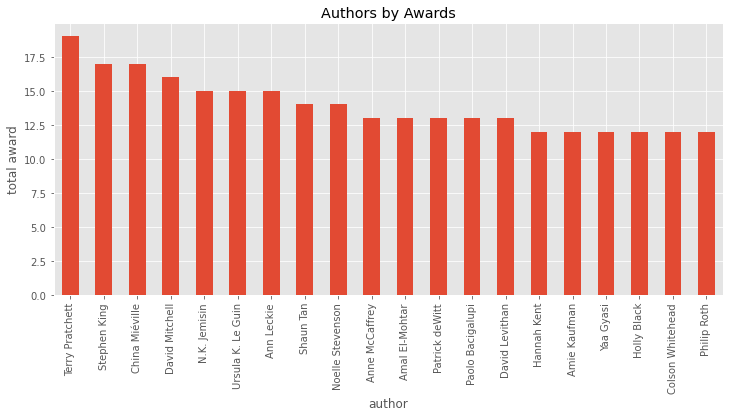

In [41]:
plt.style.use('ggplot')

def make_plot(df, x_label, y_label, title, n=all, kind='bar'):
    if n is all:
        n = df.shape[0]
    # _, ax = plt.subplots(figsize=(12,10))
    df.head(n).plot(kind=kind,legend=None,figsize=(12,5))
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)

y_label = "total award"
x_label = "author"
title = "Authors by Awards"
df_data = df_author_awards
make_plot(df_data,x_label, y_label, title, 20)

### Sort by publishing year and get their mean average ratings

In [42]:
year_ratings = df.groupby('original_publish_year')['minmax_norm_ratings'].mean().sort_values( ascending=False)
dic_year_ratings = dict(zip(year_ratings.index, year_ratings.values))

df_year_ratings = pd.DataFrame.from_dict(dic_year_ratings, orient='index')
# df_year_ratings.head()

### Plot Years and their mean average ratings

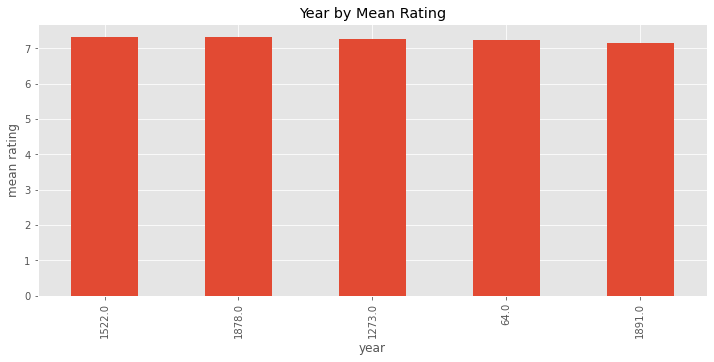

In [43]:
y_label = "mean rating"
x_label = "year"
title = "Year by Mean Rating"
df_data = df_year_ratings
make_plot(df_data,x_label, y_label, title, 5)

### Sort by author and check who has highest average rating

In [44]:
author_ratings = df.groupby('author')['avg_rating'].mean().sort_values( ascending=False)
dic_author_ratings = dict(zip(author_ratings.index, author_ratings.values))

df_author_ratings = pd.DataFrame.from_dict(dic_author_ratings, orient='index')
# df_author_ratings.head()

### Plot Authors and their mean average ratings

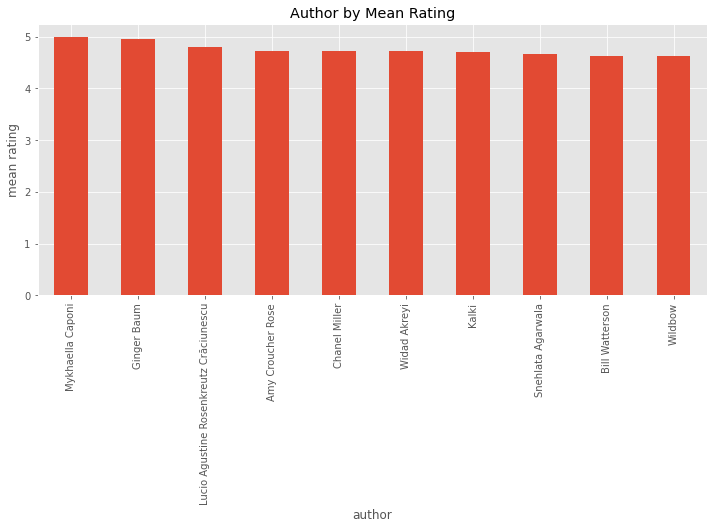

In [45]:
y_label = "mean rating"
x_label = "author"
title = "Author by Mean Rating"
df_data = df_author_ratings
make_plot(df_data,x_label, y_label, title, 10)

### Check if book series are rated better than non series books

In [46]:
series_ratings = df.groupby('series')['minmax_norm_ratings'].mean().sort_values( ascending=False)
# series_ratings

### Plot Series and their mean average ratings

(-1.1087833307443347,
 1.1004182538449683,
 -1.1119843903035023,
 1.1061625740285963)

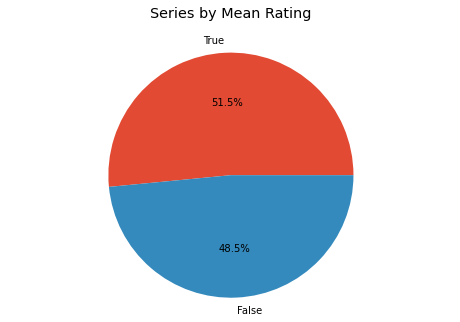

In [47]:
title = "Series by Mean Rating\n"
pie_data=series_ratings.values
pie_labels=series_ratings.index.values

fig, ax = plt.subplots(figsize=(8,5))
plt.title(title)
ax.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', shadow=False)
ax.axis('equal')

### Check if book series are more ratings than non series books

In [48]:
#df[ (df['num_ratings'] < df['num_ratings'].std()) & (df['avg_rating']>4) ].sort_values(by=['num_ratings'], ascending=[True])

series_size = df.groupby('series').size().sort_values( ascending=False)
# series_size


### Plot Series and their total number of ratings

(-1.109599868333887, 1.100457136587328, -1.114513042766504, 1.107391428376819)

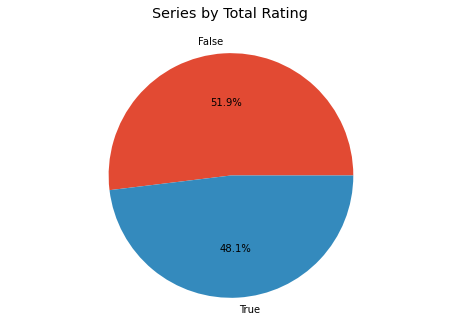

In [49]:
title = "Series by Total Rating\n"
pie_data=series_size.values
pie_labels=series_size.index.values

fig, ax = plt.subplots(figsize=(8,5))
plt.title(title)
ax.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', shadow=False)
ax.axis('equal')

### Get genre and places total counts and mean average ratings

In [50]:
df = df.replace({'places': {np.nan: '[]'}})

genres_rating = {}
genres_counts = {}

places_rating = {}
places_counts = {}

genres,places,avg_rating = df.genres, df.places, df.avg_rating

for id in range(len(avg_rating)):
    clean_genre = ast.literal_eval(genres[id])
    clean_places = ast.literal_eval(places[id])
    if len(clean_genre) != 0:
        for ng in clean_genre:
            for i in ng.split('>'):
                genr = i.strip()
                if genr in genres_rating:
                    genres_rating[genr].append(avg_rating[id])
                else:
                    genres_rating[genr] = [avg_rating[id]]
                if genr in genres_counts:
                    genres_counts[genr] += 1
                else:
                    genres_counts[genr] = 1
    #for places
    if len(clean_places) != 0:
        for cp in clean_places:
            plac = cp.strip()
            if plac in places_rating:
                places_rating[plac].append(avg_rating[id])
            else:
                places_rating[plac] = [avg_rating[id]]
            if plac in places_counts:
                places_counts[plac] += 1
            else:
                places_counts[plac] = 1

#genres
for g in genres_rating.keys():
    genres_rating[g] = np.round(np.mean(genres_rating[g]),decimals=3)

dic_genres_rating = dict(zip(genres_rating.keys(), genres_rating.values()))
df_genres_rating = pd.DataFrame.from_dict(dic_genres_rating, orient='index',\
    columns=['mean_ratings']).sort_values(by='mean_ratings',ascending=False)

dic_genres_counts = dict(zip(genres_counts.keys(), genres_counts.values()))
df_genres_counts = pd.DataFrame.from_dict(dic_genres_counts, orient='index',\
    columns=['total_counts']).sort_values(by='total_counts',ascending=False)

#places
for g in places_rating.keys():
    places_rating[g] = np.round(np.mean(places_rating[g]),decimals=3)

dic_places_rating = dict(zip(genres_rating.keys(), genres_rating.values()))
df_places_rating = pd.DataFrame.from_dict(dic_places_rating, orient='index',\
    columns=['mean_ratings']).sort_values(by='mean_ratings',ascending=False)

dic_places_counts = dict(zip(places_counts.keys(), places_counts.values()))
df_places_counts = pd.DataFrame.from_dict(dic_places_counts, orient='index',\
    columns=['total_counts']).sort_values(by='total_counts',ascending=False)

df_genres_rating.head()
df_genres_counts.head()

df_places_rating.head()
df_places_counts.head()


,total_counts
"London, England",58
"New York City, New York",52
The United States of America,41
Paris,29
"Chicago, Illinois",23


### Plot Genres and their mean average ratings

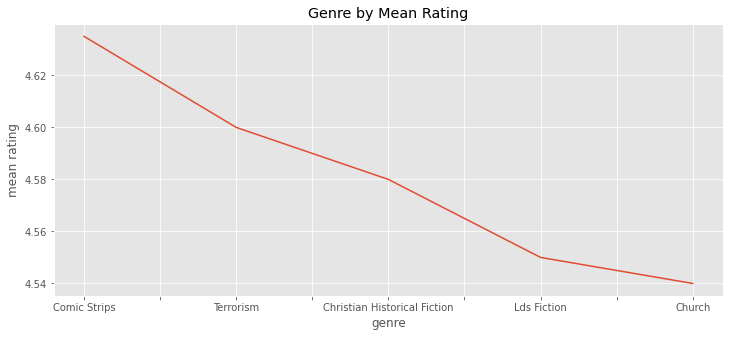

In [51]:
y_label = "mean rating"
x_label = "genre"
title = "Genre by Mean Rating"
df_data = df_genres_rating
make_plot(df_data,x_label, y_label, title, 5, kind='line')

### Plot Genres and their total counts

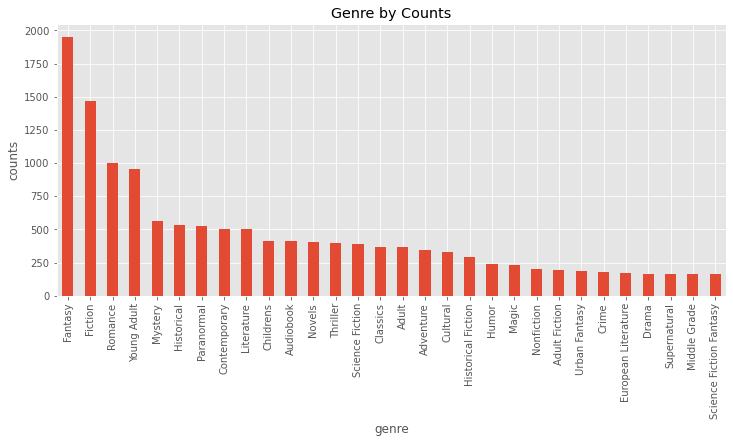

In [52]:
y_label = "counts"
x_label = "genre"
title = "Genre by Counts"
df_data = df_genres_counts
make_plot(df_data,x_label, y_label, title, 30, kind='bar')

### Plot Places and their mean average ratings

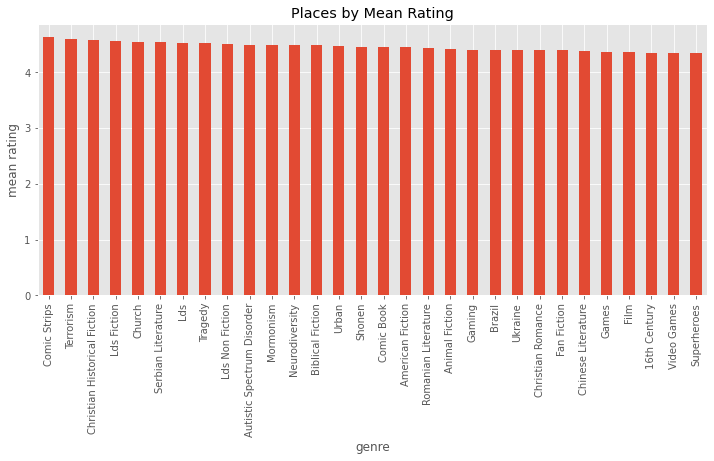

In [53]:
y_label = "mean rating"
x_label = "genre"
title = "Places by Mean Rating"
df_data = df_places_rating
make_plot(df_data,x_label, y_label, title, 30, kind='bar')

### Plot Places and their total counts

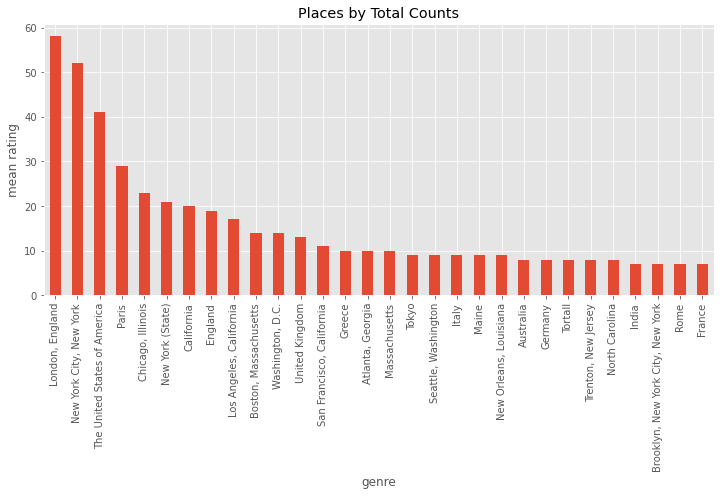

In [54]:
y_label = "mean rating"
x_label = "genre"
title = "Places by Total Counts"
df_data = df_places_counts
make_plot(df_data,x_label, y_label, title, 30, kind='bar')

### Plot Average rating and Number of views

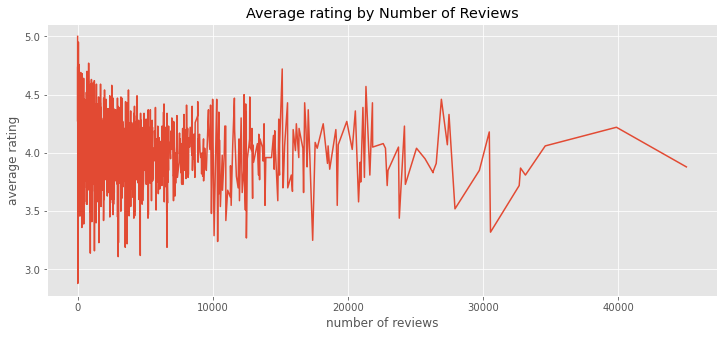

In [55]:
views_ratings = df.groupby('author')['avg_rating'].mean().sort_values( ascending=False)
dic_views_ratings = dict(zip(df.num_reviews, df.avg_rating))

df_views_ratings = pd.DataFrame.from_dict(dic_views_ratings, orient='index').sort_index(ascending=False)
df_views_ratings.head()

y_label = "average rating"
x_label = "number of reviews"
title = "Average rating by Number of Reviews"
df_data = df_views_ratings
make_plot(df_data,x_label, y_label, title, n=all, kind='line')


### Plot Number of Pages and Year

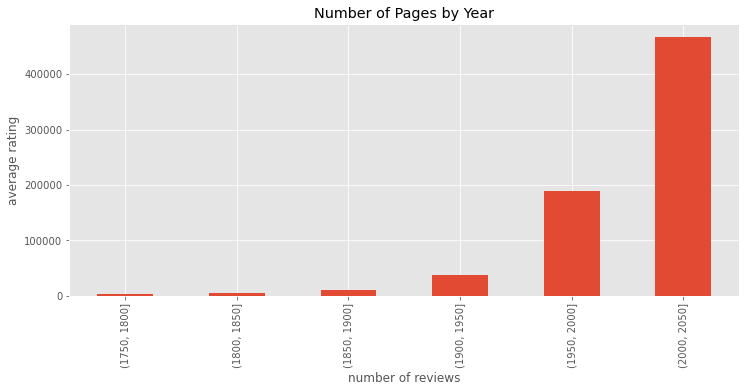

In [56]:
df_year = df.original_publish_year
df[['original_publish_year','num_pages']].groupby(pd.cut(df_year, np.arange(df_year.min(), df_year.max()+1, 10))).sum()
d=df[['original_publish_year','num_pages']].groupby(by='original_publish_year').sum().sort_values('original_publish_year')
di = d.index.values

def plot_pages_year(df,start,end,interval,n=all,kind='bar'):
    df_year_pages = df.groupby(pd.cut(df.index, np.arange(start-interval, end+interval, interval))).sum()
    y_label = "average rating"
    x_label = "number of reviews"
    title = "Number of Pages by Year"
    make_plot(df_year_pages,x_label, y_label, title, n=n, kind=kind)

start=1800#di.min()
end=2020#di.max()
interval=50

plot_pages_year(d,start,end,interval,kind='bar')

### Display frequent occurring words in description

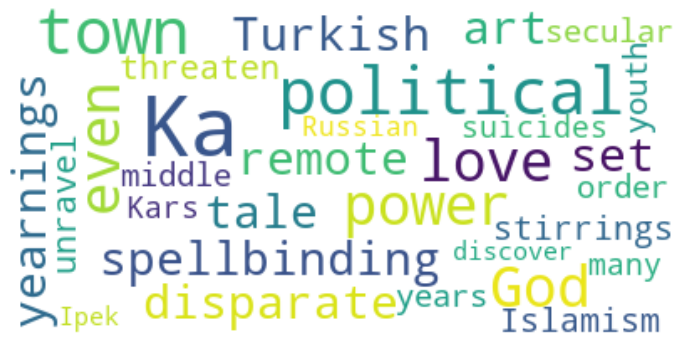

In [57]:
def text_by_image(df,option,count=100,id=all):
    # if id is all:
    #     text = ' '.join([str(d) for d in df])
    # else:
    #     text = df[id]
    text = df['description'][df.title == option].values[0]
    # print(text)

    # Create and generate a word cloud image:
    wordcloud = WordCloud(max_font_size=50, max_words=count, background_color="white").generate(text)
    _, ax = plt.subplots(figsize=(12,10))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
option = df.iloc[0,:]['title']
text_by_image(df,option,30,6)